"""
This file preprocesses plankton data by combining environmental measurements from a master table with morphological 
features from individual CSV files. It filters for specific zooplankton classes (including Calanoid, Cyclopoid, 
Bosmina, etc.), merges relevant physical measurements (such as area, circularity, and diameter) with environmental 
variables (water temperature, depth, precipitation), and performs initial exploratory data analysis through 
statistical summaries and visualizations. The processed data is saved as a merged dataset for further analysis.

The processed data is not saved on Github, but is saved in the folder "plankton_data/plankton_data_csv"
"""

In [2]:
import sys
print("Python path:", sys.executable)

Python path: /opt/anaconda3/bin/python


In [1]:
### Import the Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [3]:

# Load the Master Table
master_table = pd.read_excel("/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/MasterTable_AI_FlowCAM.xlsx")

# Display column names
print(master_table.columns)

# Check for constant or mostly empty columns
constant_columns = [col for col in master_table.columns if master_table[col].nunique() <= 1]
print("Constant Columns:", constant_columns)


Index(['tifffile', 'csvfile', 'Year', 'SAM', 'Month', 'Day', 'Rep', 'repnum',
       'Key', 'Loc', 'SITE', 'DOY', 'gdd2', 'WaterT', 'LAT0', 'LAT1', 'LON0',
       'LON1', 'avgdepth', 'trawltime', 'EFFSPEED', 'MinDepth', 'MaxDepth',
       'XANGLE', 'PRECIP', 'XWAVEHT', 'WIND', 'CLOUD_PC', 'distshore', 'FR',
       'volbest', 'WhitefishDen', 'UnknwCoregonine', 'CiscoDen', 'Exposure',
       'SmeltDen', 'YPerchDen', 'BurbotDen', 'OtherFishDen'],
      dtype='object')
Constant Columns: []


In [4]:

# Drop unnecessary columns
columns_to_drop = ["Key", "Rep", "trawltime", "EFFSPEED", "volbest", "FR"]
master_table = master_table.drop(columns=columns_to_drop, errors='ignore')

# Create the AvgDepth column and remove MinDepth and MaxDepth columns
if "MinDepth" in master_table.columns and "MaxDepth" in master_table.columns:
    master_table["AvgDepth"] = master_table[["MinDepth", "MaxDepth"]].mean(axis=1)
    master_table = master_table.drop(columns=["MinDepth", "MaxDepth"], errors='ignore')

In [5]:
#print the column names of the master_table
print("Current columns in master_table:")
print(master_table.columns)

Current columns in master_table:
Index(['tifffile', 'csvfile', 'Year', 'SAM', 'Month', 'Day', 'repnum', 'Loc',
       'SITE', 'DOY', 'gdd2', 'WaterT', 'LAT0', 'LAT1', 'LON0', 'LON1',
       'avgdepth', 'XANGLE', 'PRECIP', 'XWAVEHT', 'WIND', 'CLOUD_PC',
       'distshore', 'WhitefishDen', 'UnknwCoregonine', 'CiscoDen', 'Exposure',
       'SmeltDen', 'YPerchDen', 'BurbotDen', 'OtherFishDen', 'AvgDepth'],
      dtype='object')


In [6]:
# Extract relevant CSV file names from the master file
# Assuming the relevant column is named 'FileName' in the master table
csv_file_names = master_table["csvfile"].dropna().unique()

# Convert the file names to a set for quick lookup
csv_file_set = set(csv_file_names)

# Print the extracted file names (optional, for verification)
print(f"Extracted {len(csv_file_set)} file names from the master table.")


Extracted 478 file names from the master table.


In [7]:
# Define the output folder
output_folder = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print(f"Output folder created at: {output_folder}")


Output folder created at: /Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv


In [16]:
useful_columns = [
    "Class",
    "Area..ABD.",           # Matches "Area"
    "Aspect.Ratio",         # Matches "Aspect Ratio"
    "Circularity",          # Matches "Circularity"
    "Compactness",          # Matches "Compactness"
    "Convexity",            # Matches "Convexity"
    "Elongation",           # Matches "Elongation"
    "Diameter..ABD.",       # Matches "Diameter (ABD)"
    "Diameter..ESD.",       # Matches "Diameter (ESD)"
    "Perimeter",            # Matches "Perimeter"
    "Intensity",            # Matches "Intensity"
    "Sigma.Intensity",      # Matches "Sigma Intensity"
    "Roughness",            # Matches "Roughness"
    "Transparency",         # Matches "Transparency
    "Image.File",           # Matches "Image File"
    "Particle.ID",          # Matches "Particle ID"
    "Image.Height",
    "Image.Width",
    "Image.X",
    "Image.Y"
]

# Target zooplankton classes
target_classes = {"Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"}

# Initialize a list to store names of files not found in the master table
files_not_in_master = []

# Define paths to the input folders
input_folders = ["/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/HURONOvlerap_csv", "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/SIMC.Overlap.csv"]

# Process each CSV file in the input folders
for folder in input_folders:
    for file_name in os.listdir(folder):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder, file_name)

            # Check if the file is in the master table
            if file_name in csv_file_set:
                try:
                    # Load the CSV file
                    data = pd.read_csv(file_path)

                    # Filter for useful columns only
                    filtered_data = data[[col for col in useful_columns if col in data.columns]]

                    # Filter rows where "Class" belongs to target classes
                    if "Class" in filtered_data.columns:
                        filtered_data = filtered_data[filtered_data["Class"].isin(target_classes)]
                    
                    # Add a new column for filename
                    filtered_data["Filename"] = file_name

                    # Save the filtered data to the new folder
                    output_path = os.path.join(output_folder, file_name)
                    filtered_data.to_csv(output_path, index=False)
                except Exception as e:
                    print(f"Error processing file {file_name}: {e}")
            else:
                # Store the file name if not in the master table
                files_not_in_master.append(file_name)

print(f"Processing complete. {len(files_not_in_master)} files were not in the master table.")


Processing complete. 103 files were not in the master table.


In [17]:
# Define the final output file path
final_output_path = os.path.join(output_folder, "combined_data.csv")

# Initialize an empty list to store DataFrames
dfs = []

# Read and concatenate all modified CSV files
for file_name in os.listdir(output_folder):
    if file_name.endswith(".csv"):
        file_path = os.path.join(output_folder, file_name)
        try:
            df = pd.read_csv(file_path)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading file {file_name}: {e}")

# Combine all DataFrames into one
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Save the combined dataset
    combined_df.to_csv(final_output_path, index=False)
    
    print(f"Successfully combined {len(dfs)} CSV files into {final_output_path}")
else:
    print("No CSV files found to combine.")


/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_50230/4130396607.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs, ignore_index=True)


Successfully combined 474 CSV files into /Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv/combined_data.csv


In [18]:

# Load the combined large CSV file
large_csv_path = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv/combined_data.csv"  # Update if needed
large_csv = pd.read_csv(large_csv_path)

# Ensure filename column is present in the large CSV
if "Filename" not in large_csv.columns:
    raise ValueError("The 'Filename' column is missing in the large CSV file.")

# Merge the master table with the large CSV on 'csvfile' (from master) and 'Filename' (from large CSV)
merged_df = master_table.merge(large_csv, left_on="csvfile", right_on="Filename", how="inner")

# Save the merged dataset
merged_output_path = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_CSV.csv"
merged_df.to_csv(merged_output_path, index=False)

print(f"Merging complete. Merged dataset saved at: {merged_output_path}")


Merging complete. Merged dataset saved at: /Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_CSV.csv


In [19]:
# Summary statistics for numerical columns

selected_columns = [
    "WaterT", "AvgDepth", "PRECIP", "gdd2", "DOY", "SmeltDen", "YPerchDen", "BurbotDen", "OtherFishDen", 
    "distshore", "Area..ABD.", "Aspect.Ratio", "Circularity", "Perimeter", "Diameter..ABD.", "Diameter..ESD."
]

# Generate summary statistics for the selected variables
summary_stats = merged_df[selected_columns].describe()

# Display the summary statistics directly
print("\nSummary Statistics of Selected Variables:")
print(summary_stats)

# Optionally, you can also display it in a more readable format:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide tables
print(summary_stats)


Summary Statistics of Selected Variables:
             WaterT      AvgDepth        PRECIP          gdd2           DOY  \
count  4.208798e+07  4.208798e+07  4.208798e+07  4.208798e+07  4.208798e+07   
mean   1.160723e+01  1.279394e+01  2.552362e+00  1.695432e+02  1.377511e+02   
std    5.007273e+00  8.631870e+00  1.061261e+01  1.270049e+02  1.272888e+01   
min    3.500000e+00  1.250000e+00  0.000000e+00  1.172000e+01  9.700000e+01   
25%    7.450000e+00  5.200000e+00  0.000000e+00  5.922941e+01  1.280000e+02   
50%    1.130000e+01  9.400000e+00  0.000000e+00  1.403749e+02  1.360000e+02   
75%    1.530000e+01  2.030000e+01  0.000000e+00  2.675861e+02  1.490000e+02   
max    2.260000e+01  3.830000e+01  6.100000e+01  4.752409e+02  1.680000e+02   

           SmeltDen     YPerchDen     BurbotDen  OtherFishDen     distshore  \
count  7.926615e+06  4.208650e+07  4.208650e+07  4.208650e+07  3.427159e+07   
mean   2.621120e-06  2.444179e-02  4.562815e-05  7.515768e-05  1.833836e+03   
std    3

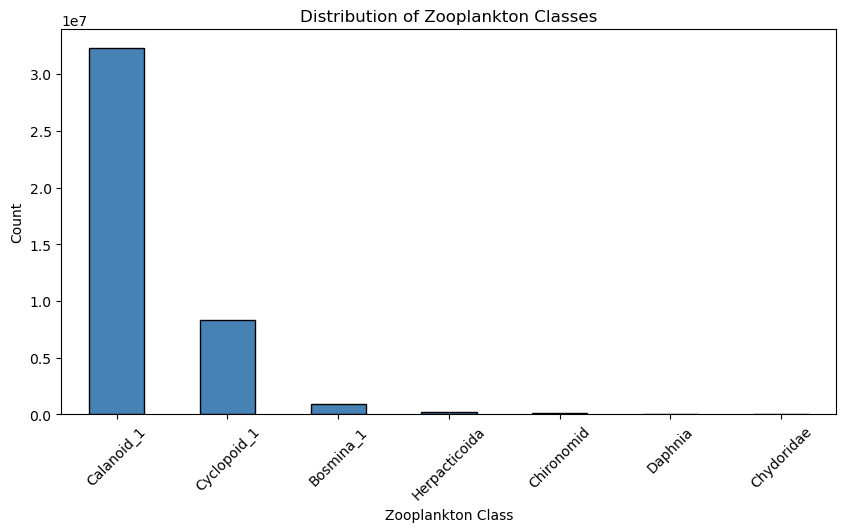

['Calanoid_1' 'Herpacticoida' 'Cyclopoid_1' 'Chironomid' 'Bosmina_1'
 'Chydoridae' 'Daphnia']


In [20]:
import matplotlib.pyplot as plt

# Count the number of observations per species
plt.figure(figsize=(10, 5))
merged_df["Class"].value_counts().plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Distribution of Zooplankton Classes")
plt.xlabel("Zooplankton Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

print(merged_df["Class"].unique())


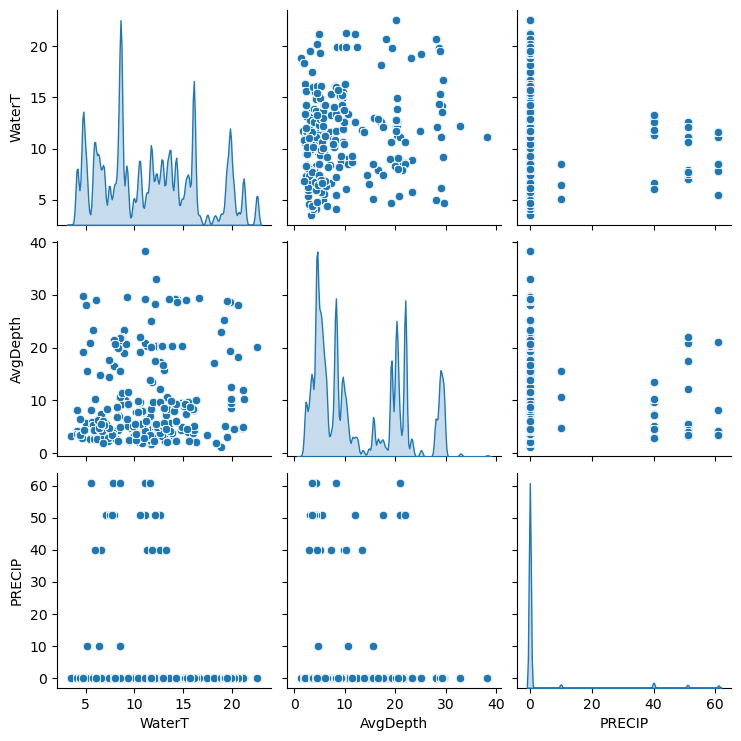

In [21]:
import seaborn as sns

# Pairplot for key environmental variables
env_features = ["WaterT", "AvgDepth", "PRECIP"]
sns.pairplot(merged_df[env_features].dropna(), diag_kind="kde")
plt.show()


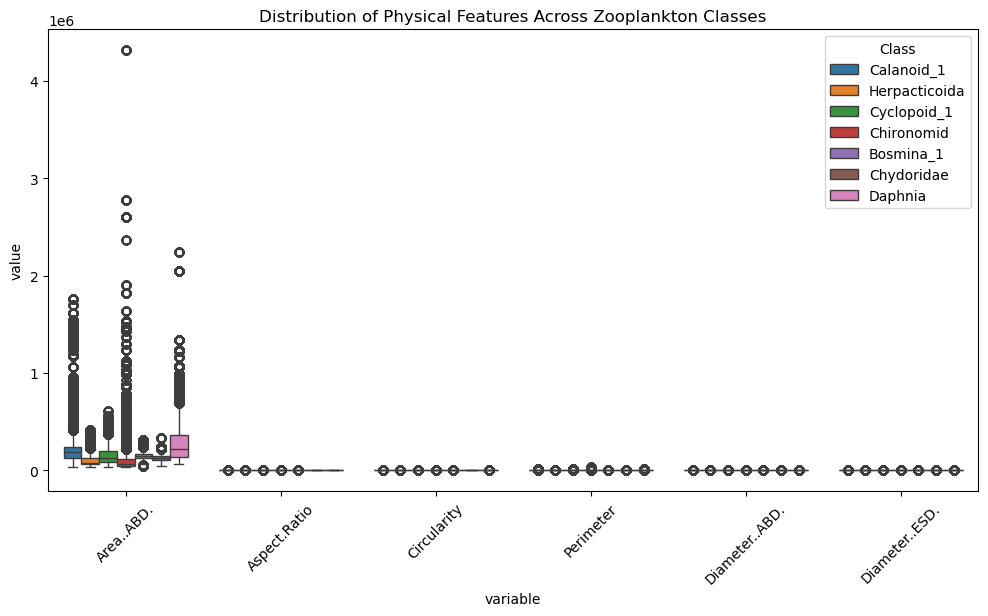

In [22]:
# Boxplot for physical measurements by species
physical_features = ["Area..ABD.", "Aspect.Ratio", "Circularity", "Perimeter", "Diameter..ABD.", "Diameter..ESD."]

plt.figure(figsize=(12, 6))
df_melted = merged_df.melt(id_vars=["Class"], value_vars=physical_features)
sns.boxplot(x="variable", y="value", hue="Class", data=df_melted)
plt.xticks(rotation=45)
plt.title("Distribution of Physical Features Across Zooplankton Classes")
plt.show()


/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_50230/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


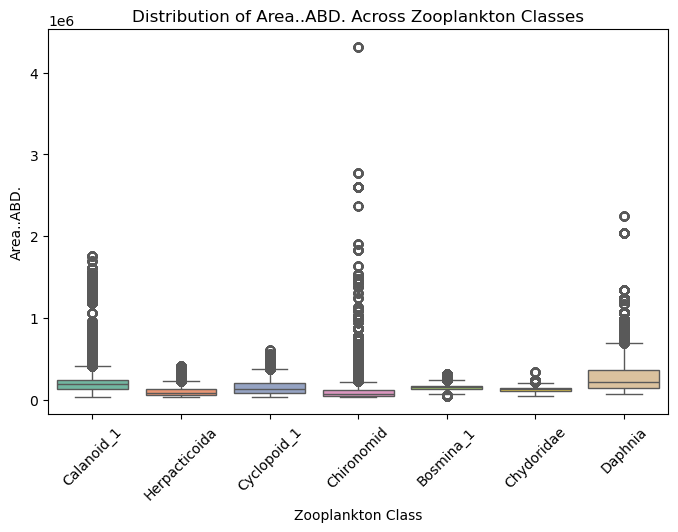

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_50230/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


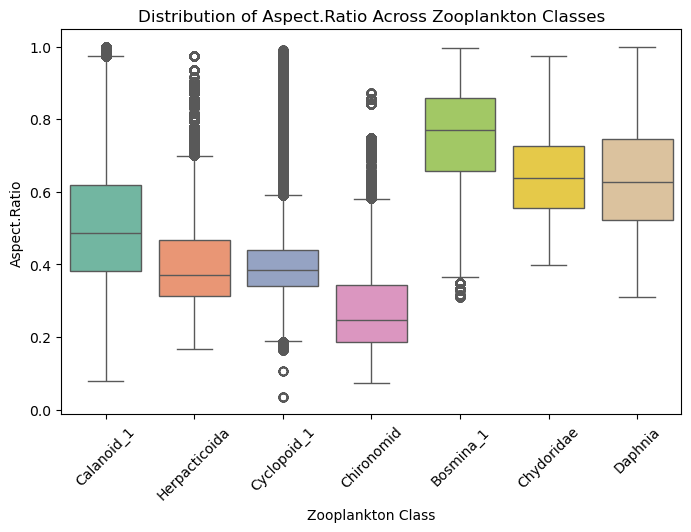

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_50230/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


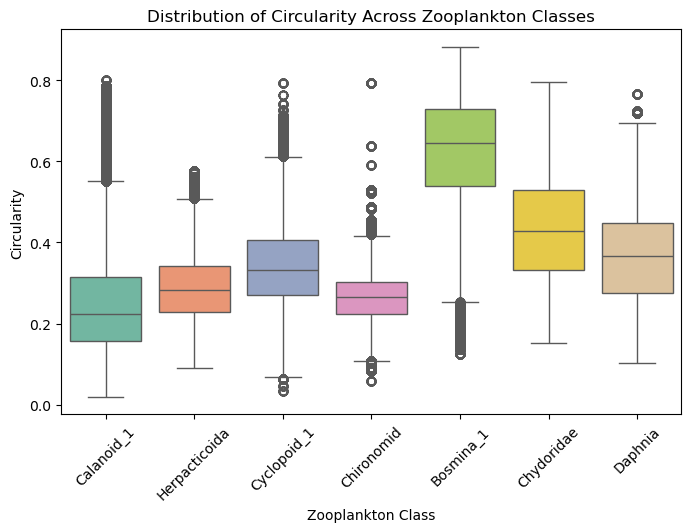

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_50230/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


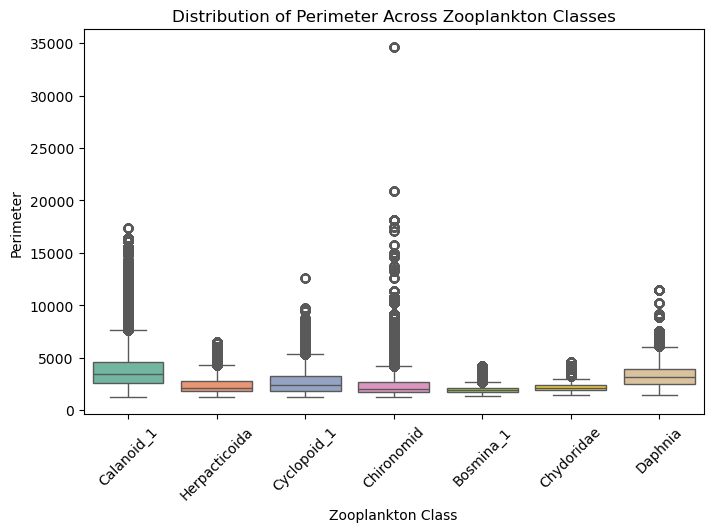

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_50230/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


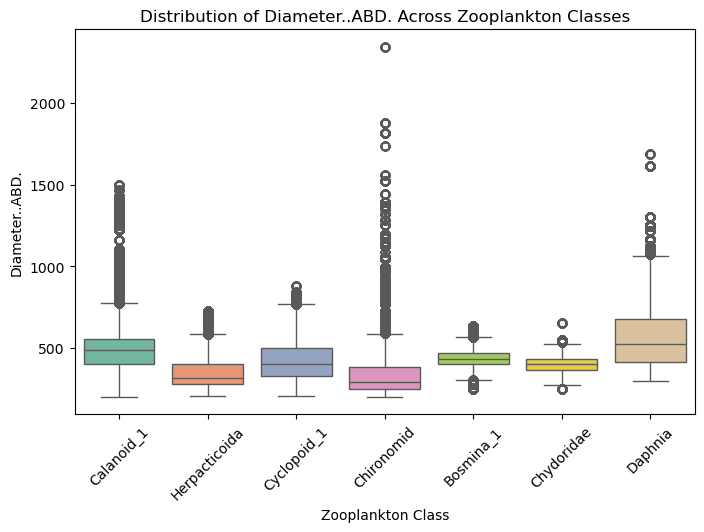

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_50230/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


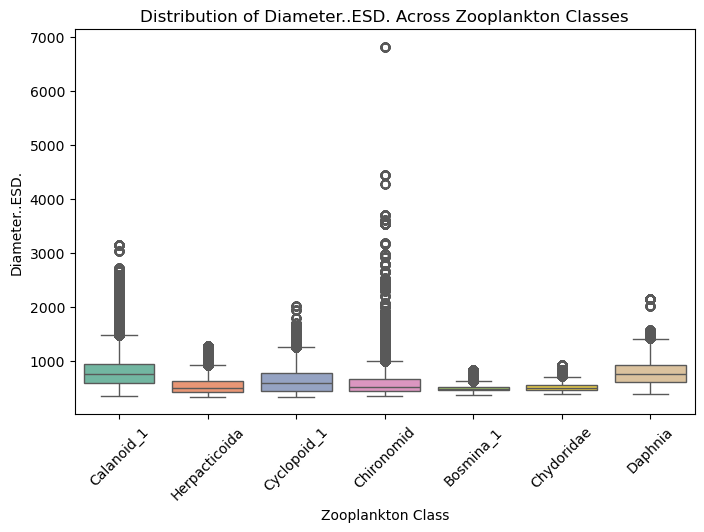

In [23]:
# List of physical features to plot separately
physical_features = [
    "Area..ABD.", "Aspect.Ratio", "Circularity", "Perimeter", "Diameter..ABD.", "Diameter..ESD."
]

# Create separate boxplots for each feature
for feature in physical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {feature} Across Zooplankton Classes")
    plt.xlabel("Zooplankton Class")
    plt.ylabel(feature)
    plt.show()

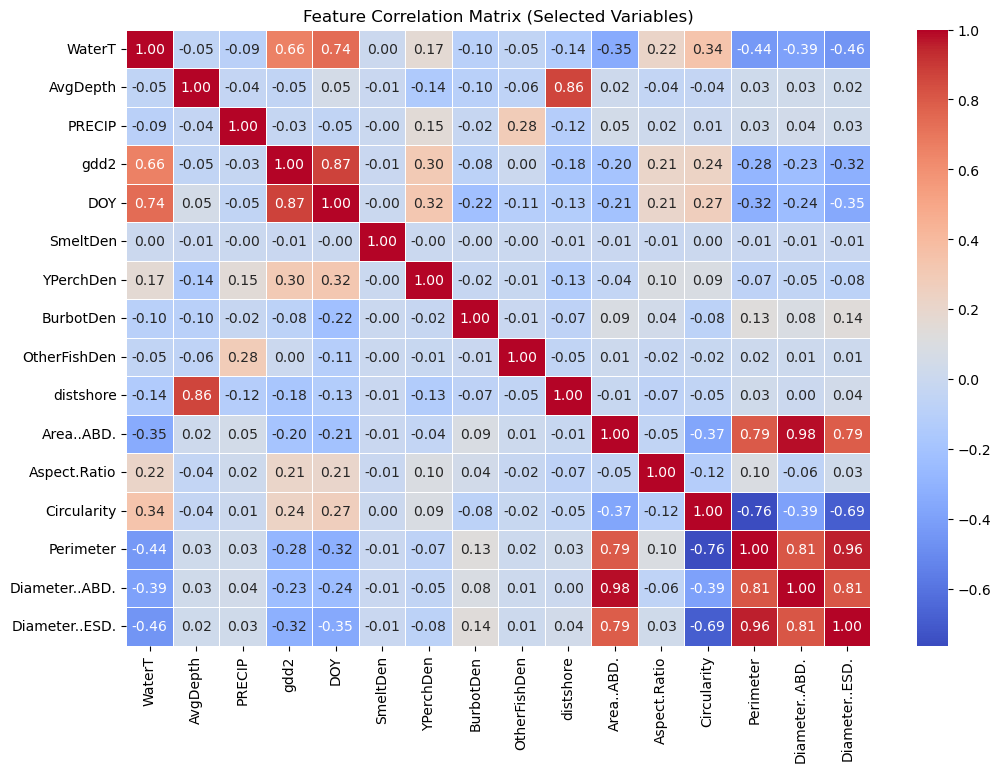

In [24]:

# Select only the relevant variables for correlation analysis
selected_columns = [
    "WaterT", "AvgDepth", "PRECIP", "gdd2", "DOY", "SmeltDen", "YPerchDen", "BurbotDen", "OtherFishDen", 
    "distshore", "Area..ABD.", "Aspect.Ratio", "Circularity", "Perimeter", "Diameter..ABD.", "Diameter..ESD."
]

# Compute the correlation matrix
corr_matrix = merged_df[selected_columns].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix (Selected Variables)")
plt.show()
